Importing the required Libraries
--------------------------------

Make Sure to first create your own virtual environment and install all the libraries from the requirements.txt file

`pip install -r requirements.txt`

In [20]:
import pandas as pd  
import numpy as np  
import matplotlib.pyplot as plt  
from sklearn.model_selection import train_test_split 
import xgboost as xgb
import os
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.metrics import explained_variance_score
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from ann_visualizer.visualize import ann_viz
import keras.utils.vis_utils
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)
%matplotlib inline

Set your working directory
--------------------------


In [21]:
os.chdir('D:\Documents-Storage\GitHub\ML_Liquid\Solubility')

Load the dataset
----------------

Everything should be in your working directory. If it throws an error, check your directory setting

In [22]:
# read data frame overall
df = pd.read_csv("aqsol.csv")

Display the first 5 rows
------------------------

In [23]:
# df.columns
df.head()

,ID,Name,InChI,InChIKey,SMILES,Solubility,SD,Ocurrences,Group,MolWt,...,NumRotatableBonds,NumValenceElectrons,NumAromaticRings,NumSaturatedRings,NumAliphaticRings,RingCount,TPSA,LabuteASA,BalabanJ,BertzCT
0,A-3,"N,N,N-trimethyloctadecan-1-aminium bromide",InChI=1S/C21H46N.BrH/c1-5-6-7-8-9-10-11-12-13-...,SZEMGTQCPRNXEG-UHFFFAOYSA-M,[Br-].CCCCCCCCCCCCCCCCCC[N+](C)(C)C,-3.616127,0.0,1,G1,392.510,...,17.0,142.0,0.0,0.0,0.0,0.0,0.00,158.520601,0.000000e+00,210.377334
1,A-4,Benzo[cd]indol-2(1H)-one,InChI=1S/C11H7NO/c13-11-8-5-1-3-7-4-2-6-9(12-1...,GPYLCFQEKPUWLD-UHFFFAOYSA-N,O=C1Nc2cccc3cccc1c23,-3.254767,0.0,1,G1,169.183,...,0.0,62.0,2.0,0.0,1.0,3.0,29.10,75.183563,2.582996e+00,511.229248
2,A-5,4-chlorobenzaldehyde,InChI=1S/C7H5ClO/c8-7-3-1-6(5-9)2-4-7/h1-5H,AVPYQKSLYISFPO-UHFFFAOYSA-N,Clc1ccc(C=O)cc1,-2.177078,0.0,1,G1,140.569,...,1.0,46.0,1.0,0.0,0.0,1.0,17.07,58.261134,3.009782e+00,202.661065
3,A-8,"zinc bis[2-hydroxy-3,5-bis(1-phenylethyl)benzo...",InChI=1S/2C23H22O3.Zn/c2*1-15(17-9-5-3-6-10-17...,XTUPUYCJWKHGSW-UHFFFAOYSA-L,[Zn++].CC(c1ccccc1)c2cc(C(C)c3ccccc3)c(O)c(c2)...,-3.924409,0.0,1,G1,756.226,...,10.0,264.0,6.0,0.0,0.0,6.0,120.72,323.755434,2.322963e-07,1964.648666
4,A-9,4-({4-[bis(oxiran-2-ylmethyl)amino]phenyl}meth...,InChI=1S/C25H30N2O4/c1-5-20(26(10-22-14-28-22)...,FAUAZXVRLVIARB-UHFFFAOYSA-N,C1OC1CN(CC2CO2)c3ccc(Cc4ccc(cc4)N(CC5CO5)CC6CO...,-4.662065,0.0,1,G1,422.525,...,12.0,164.0,2.0,4.0,4.0,6.0,56.60,183.183268,1.084427e+00,769.899934


Select the favourable parameters
--------------------------------

The Best Parameters are selected on the basis of Phik Correlation to give the highest accuracy

In [24]:
# X - NumHAcceptors, NumHDonors, NumAromaticRings, NumSaturatedRings, NumAliphaticRings, MolMR
# Y - Solubility 
# Merged dataframe to provide pair plot 

X = df.loc[:, ['MolMR','NumHAcceptors', 'NumHDonors', 'NumAromaticRings', 'NumSaturatedRings', 'NumAliphaticRings','HeavyAtomCount','MolLogP','BalabanJ']]
Y = df.loc[:, ['Solubility']]
merge = df.loc[:, ['MolMR','MolLogP','BalabanJ','NumHAcceptors', 'NumHDonors', 'NumAromaticRings', 'NumSaturatedRings', 'NumAliphaticRings','HeavyAtomCount','Solubility']]

Split the new dataset into test and train batches
-------------------------------------------------

This ensures repeatability between the various models used

In [25]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.25, random_state = 0)

1) Linear Regression:
---------------------

- A basic regressive model. It doesnt not perform well on large and complex datasets but is overall a decent model for beginners
- We score the trained model on itself


In [46]:
regressor = LinearRegression()

reg = regressor.fit(X_train, Y_train)

print(reg.score (X_train, Y_train) * 100, '%')

45.528518523060434 %


2) XGBoost Regressor:
---------------------

- XGBoost is an optimized distributed gradient boosting library designed to be highly efficient, flexible and portable. It implements machine learning algorithms under the Gradient Boosting framework.
- We use the Regressor variant as we aim at predicting the Aqueous solubility of the compounds
- To find the best parameters for the model, we use Grid Search. This essentially take in a grid of parameters and trains the model on each and every one of them.
- We compare the accuracy of every set and get the best possible parameters.


In [27]:
xgb = xgb.XGBRegressor()

parameters = {'nthread':[4],
              'objective':['reg:linear'],
              'learning_rate': [0.005, 0.01, 0.03, 0.05, .07],
              'max_depth': [5, 6, 7],
              'min_child_weight': [3, 4, 5],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7, 0.9, 1.0],
              'n_estimators': [500]}

xgb_grid = GridSearchCV(xgb,
                        parameters,
                        cv = 2,
                        n_jobs = -1,
                        verbose=True)
xgb_grid.fit(X_train, Y_train)

print('XGBoost Regressor Score is {}'.format(xgb_grid.score(X_train, Y_train)))

Fitting 2 folds for each of 135 candidates, totalling 270 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   17.4s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed:  2.4min finished
[18:30:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[18:30:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


XGBoost Regressor Score is 0.8357426529504035


Getting the Best Parameters
---------------------------

- This is for us to visualize. 

In [28]:
xgb_grid.best_params_

{'colsample_bytree': 0.7,
 'learning_rate': 0.01,
 'max_depth': 7,
 'min_child_weight': 4,
 'n_estimators': 500,
 'nthread': 4,
 'objective': 'reg:linear',
 'silent': 1,
 'subsample': 0.7}

3) Neural Network Model:
------------------------

- Now we enter into Deep Learning Techiniques.
- The Neural Network models tries to simulate the working of the human brain and produce models accordingly.
- It consists of Neurons whose connections are based on weights and biases.
- Its is very flexible and popularly used for Classification, Image Recognition, etc..
- We are using it for linear type output.

In [29]:
NN_model = Sequential()

# The Input Layer :
NN_model.add(Dense(128, kernel_initializer='normal',input_dim = X_train.shape[1], activation='relu'))

# The Hidden Layers :
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))

# The Output Layer :
NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

# Compile the network :
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
NN_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 128)               1280      
_________________________________________________________________
dense_6 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_7 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_8 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 257       
Total params: 166,145
Trainable params: 166,145
Non-trainable params: 0
_________________________________________________________________


Different Visualizations of the Neural Network Model
----------------------------------------------------

- First, we use the basic `plot_model` from `keras` to visualize the different layers of our model.
- Although this is not very fancy to look at, it gives us a basic understand of our model.

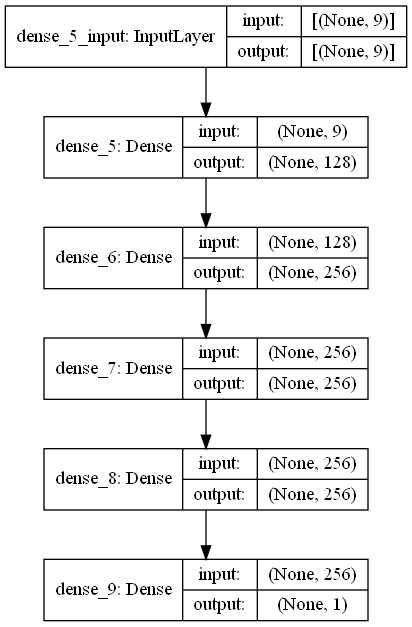

In [30]:
keras.utils.vis_utils.plot_model(NN_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

Third Party library for better visualization of the model
---------------------------------------------------------

- We are using an open source library called `ann_visualizer` which creates a better visualization of our model.
- This library is amazing and produces incredible visualizations.
- You can find it on GitHub at `https://github.com/RedaOps/ann-visualizer`

In [47]:
ann_viz(NN_model, title="My first neural network")

Creating a Checkpoint
---------------------

- We create a checkpoint (basically like a game save) to access previous trains of the model.

In [32]:
checkpoint_name = 'model_checkpoints/Weights-{epoch:03d}--{val_loss:.5f}.hdf5'
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]

Training the Neural Network Model:
----------------------------------

- This might take a while depending on your computer. 

In [33]:
NN_model.fit(X_train, Y_train, epochs=500, batch_size=32, validation_data=(X_test, Y_test), callbacks=callbacks_list)

lute_error: 0.8227

Epoch 00409: val_loss did not improve from 0.79022
Epoch 410/500
234/234 [==============================] - 0s 1ms/step - loss: 0.4378 - mean_absolute_error: 0.4378 - val_loss: 0.8030 - val_mean_absolute_error: 0.8030

Epoch 00410: val_loss did not improve from 0.79022
Epoch 411/500
234/234 [==============================] - 0s 1ms/step - loss: 0.4090 - mean_absolute_error: 0.4090 - val_loss: 0.8152 - val_mean_absolute_error: 0.8152

Epoch 00411: val_loss did not improve from 0.79022
Epoch 412/500
234/234 [==============================] - 0s 1ms/step - loss: 0.4315 - mean_absolute_error: 0.4315 - val_loss: 0.8156 - val_mean_absolute_error: 0.8156

Epoch 00412: val_loss did not improve from 0.79022
Epoch 413/500
234/234 [==============================] - 0s 1ms/step - loss: 0.4107 - mean_absolute_error: 0.4107 - val_loss: 0.7962 - val_mean_absolute_error: 0.7962

Epoch 00413: val_loss did not improve from 0.79022
Epoch 414/500
234/234 [==============================

Selecting the best checkpoint file
----------------------------------

- Make sure to select the checkpoint file with the lowest `val_loss`. 
- The files are in the format `Weights-<epoch>--<val_loss>.hdf5`
- Search for the Highest `epoch` or the lowest `val_loss`

In [35]:
weights_file = 'model_checkpoints/Weights-293--0.79022.hdf5' # choose the best checkpoint 
NN_model.load_weights(weights_file) # load it
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])

Predicting the test values of all the models
--------------------------------------------

In [48]:
NN_predictions = NN_model.predict(X_test)

LG_pred = regressor.predict(X_test)

XGB_pred = xgb_grid.predict(X_test)

Explained Variance Score of all the three model's test data predictions
-----------------------------------------------------------------------

In [50]:
NN_score = explained_variance_score(Y_test, NN_predictions)

XGB_Score = explained_variance_score(Y_test, xgb_pred)

REG_Score = explained_variance_score(Y_test, Y_pred)

In [53]:
print("Linear Regression Model's Explained Variance Score is {} %\n\nXGBoost Regressor with basic GridSearchCV's Explained Variance Score is {} %\n\nNeural Network Model's Explained Variance Score is {} %".format(REG_Score * 100, XGB_Score * 100, NN_score * 100))

Linear Regression Model's Explained Variance Score is 38.45539171640904 %

XGBoost Regressor with basic GridSearchCV's Explained Variance Score is 72.78709469274276 %

Neural Network Model's Explained Variance Score is 74.46781819518024 %


In [42]:
# more information about MAE, MSE and RMSE 

print('Linear Regression Mean Absolute Error:', metrics.mean_absolute_error(Y_test, Y_pred))  
print('Linear Regression Mean Squared Error:', metrics.mean_squared_error(Y_test, Y_pred))  
print('Linear Regression Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(Y_test, Y_pred)))
print('Mean:', Y_test.mean())
print('Linear Regression Mean:', Y_pred.mean())

Linear Regression Mean Absolute Error: 1.3428191571705763
Linear Regression Mean Squared Error: 3.4880747284419513
Linear Regression Root Mean Squared Error: 1.8676388110236817
Mean: Solubility   -2.888173
dtype: float64
Linear Regression Mean: -2.8730009392804967


In [43]:
print('Linear Regression Mean Absolute Error:', metrics.mean_absolute_error(Y_test, xgb_pred))  
print('Linear Regression Mean Squared Error:', metrics.mean_squared_error(Y_test, xgb_pred))  
print('Linear Regression Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(Y_test, xgb_pred)))
print('Mean:', Y_test.mean())
print('XGBRegressor Mean:', xgb_pred.mean())

Linear Regression Mean Absolute Error: 0.8680589882769312
Linear Regression Mean Squared Error: 1.5430253164798824
Linear Regression Root Mean Squared Error: 1.2421857012861977
Mean: Solubility   -2.888173
dtype: float64
XGBRegressor Mean: -2.8595262


In [44]:
yt_score = regressor.score(X_test, Y_test)
xgbt_score = xgb_grid.score(X_test, Y_test)

In [45]:
print("Test Score of Linear Regression is {} %\nTest Score of XGBRegressor is {} %".format(yt_score * 100, xgbt_score * 100))

Test Score of Linear Regression is 38.45132992367372 %
Test Score of XGBRegressor is 72.772614259368 %
